《CUDA C编程权威指南》

# 2. CUDA编程模型

## 2.1 CUDA编程模型概述
### 2.1.1 编程结构
- 每个GPU和CPU的内存都由一条PCI-Express总线分隔开
- 主机
  - CPU及其内存
  - 串行执行
  - 代码使用CUDA C编写，nvcc编译
- 设备
  - GPU及其内存
  - 并行执行
  - 代码使用ANSI C编写，nvcc编译
- 编程模式
  - 数据：CPU->GPU（同步）
  - 计算：调用GPU执行kernel（异步）
  - 数据：GPU->CPU

### 2.1.2 内存管理
相关函数
- 内存申请：malloc、cudaMalloc
  - 申请一定字节的线性内存
- 内存拷贝：memcpy、cudaMemcpy
  - 同步拷贝数据（执行kernel是异步的）
    - cudaMemcpyHostToHost
    - cudaMemcpyHostToDevice
    - cudaMemcpyDeviceToHost
    - cudaMemcpyDeviceToDevice
- 内存填充：memset、cudaMemset
- 内存释放：free、cudaFree

内存层次结构
- 一级：GPU的共享内存，CPU的缓存
- 二级：GPU的全局内存，CPU的系统内存

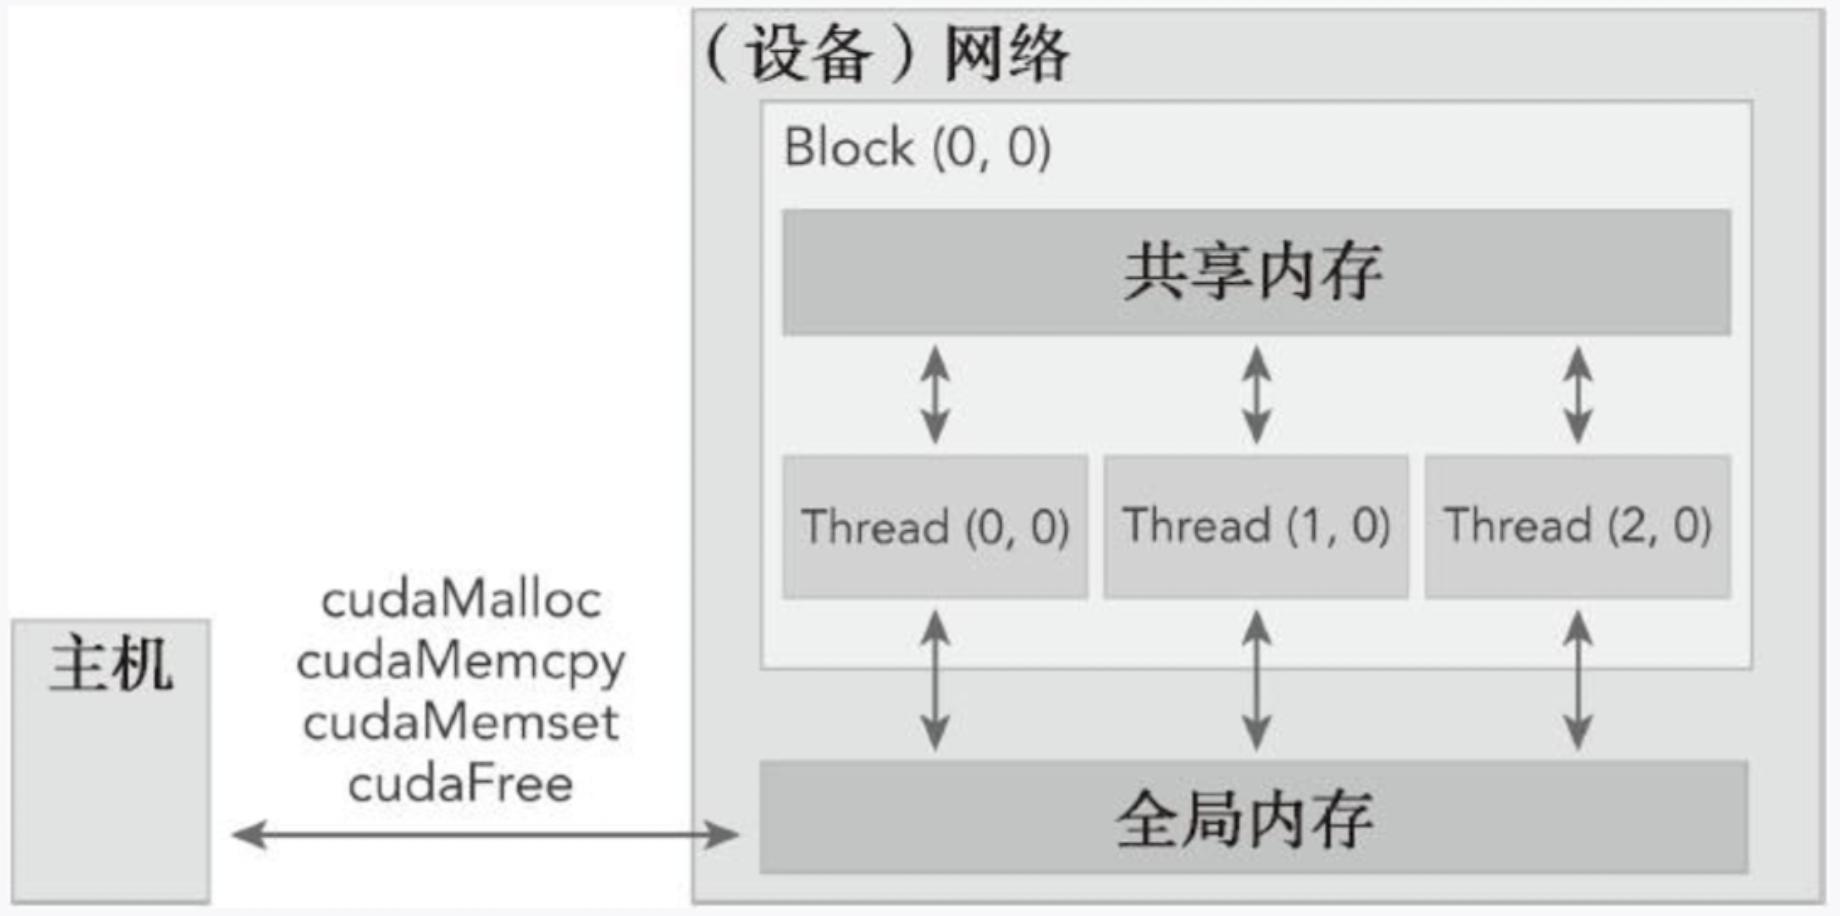

错误判断
- 除了内核启动之外的CUDA调用都会返回一个错误枚举cudaError_t
- 可通过cudaGetErrorString将cudaError_t转为可读错误消息

常见错误
- 不同内存空间的不恰当引用
    - gpuRef = d_C ❌
    - cudaMemcpy(gpuRef, d_C, nBytes, cudaMemcpyDeviceToHost) ✅
    - 为避免这种错误，CUDA 6.0提出统一寻址，使用一个指针访问GPU和CPU的内存

📝 2.1_sumArraysOnHost.c

### 2.1.3 线程管理
grid
- 定义：一个kernel启动产生的所有block
- 内存共享：全局内存空间
- 协作：无法协作

block
- 定义：一组线程组成的线程组
- 内存共享：共享内存
- 协作：同步、共享内存

block和线程的索引
- 用途：定位、区分线程
- blockIdx：block在grid的索引
- threadIdx：thread在block的索引

grid和block的维度
- gridDim：grid维度，表示x、y、z维度上的block数量
- blockDim：block维度，表示x、y、z维度上的线程数量

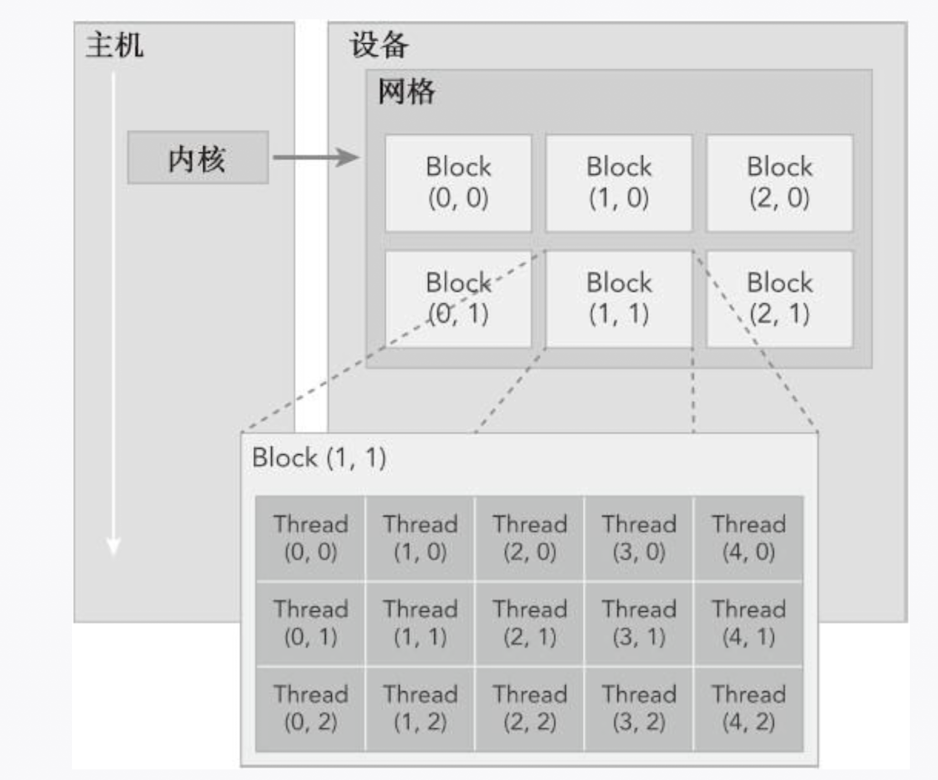

📌 调用kernel时，CUDA会生成相应的索引和维度

📝 2.2_checkDimension.cu 📝 2.3_defineGridBlock.cu

### 2.1.4 启动一个CUDA kernel

CUDA kernel是对C函数的拓展，增加了<<<>>>执行配置：```kernel_name <<<grid, block>>> (argument list)```，其中grid是grid维度，即block数目，block是block维度，即每个block的线程数。

例如```kernel_name<<<4, 8>>>(argument list)```对应的线程布局如下：

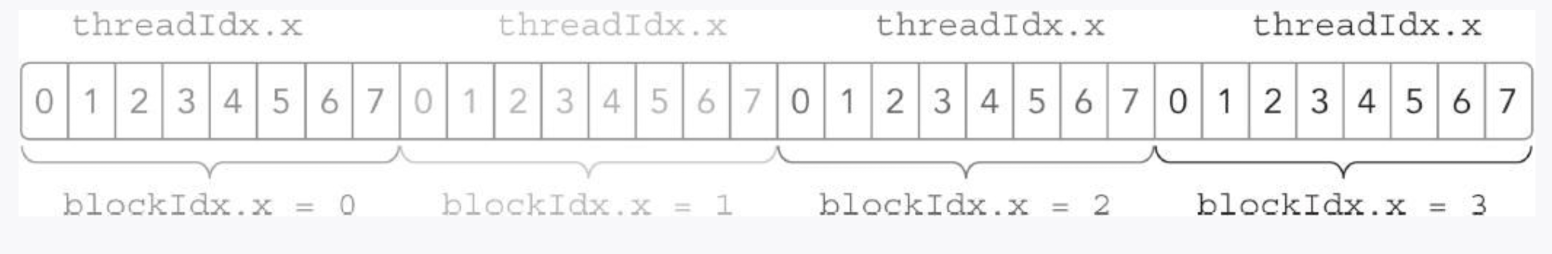

利用blockIdx.x和threadIdx.x可以
- 在grid中唯一表示线程
- 建立线程和数据的映射

CUDA kernel的调用是异步的，可以通过```cudaError_t cudaDeviceSynchronize(void)```等待所有CUDA kernel执行结束。

### 2.1.5 编写CUDA kernel
根据执行、调用限定，函数分为
- \_\_global__：在设备端执行，在主机端调用
- \_\_device__：在设备端执行，在设备端调用
- \_\_host__：在主机端执行，在主机端调用

📌 __device__函数通常用来抽离通用代码、复用代码；__device__和__host__可同时使用，允许相同的代码在两种不同的执行环境中使用

在设备端执行的CUDA kernel
- 只允许访问设备内存
- 必须返回void
- 不支持可变参数：违反SIMT执行相同指令的原则
- 不支持静态变量：并发不安全、初始化复杂
- 异步执行

### 2.1.6 验证CUDA kernel
- 分别在device端和host端执行，对比计算结果，误差不大于1.0E-8
- 将执行参数设置为<<<1, 1>>>，模拟串行执行，有助于调试和验证

### 2.1.7 处理错误
许多CUDA调用是异步的，可定义一个错误处理宏，统一处理错误
```c
#define CHECK(call) {
    const cudaError_t error = call;
    if (err != cudaSuccess) {
        printf("Error: %s:%d, ", __FILE__, __LINE__);
        printf("code: %d, reason: %s\n", error, cudaGetErrorString(error));
        exit(1);
    }
}
```
在CUDA调用时使用宏
```c
CHECK(cudaMemcpy(d_C, gpuRef, nBytes, cudaMemcpyHostToDevice));
```
也可以等待CUDA调用结束后使用宏，不过仅为调试目的，否则该检查点会阻塞host端线程
```c
kernel_function<<<grid, block>>> (argument list);
CHECK(cudaDeviceSynchronize());
```

### 2.1.8 编译和执行 
📝 2.4_sumArraysOnGPU-small-case.cu

## 2.2 给CUDA kernel计时

### 2.2.1 用CPU计时器计时
使用`gettimeofday`获取1970-01-01零点以来经过的秒数
```c
double cpuSecond() {
    struct timeval tp;
    gettimeofday(&tp, NULL);
    return ((double)tp.tv_sec + (double)tp.tv_usec*1.e-6);
}
```
使用cpuSecond函数测试核函数
```c
double iStart = cpuSecond();
kernel_name<<<grid, block>>> (argument list);
cudaDeviceSynchronize();
double iElaps = cpuSecond() - iStart;
```
为了解决线程数大于向量元素的情况，需要限制kernel不能非法访问全局内存

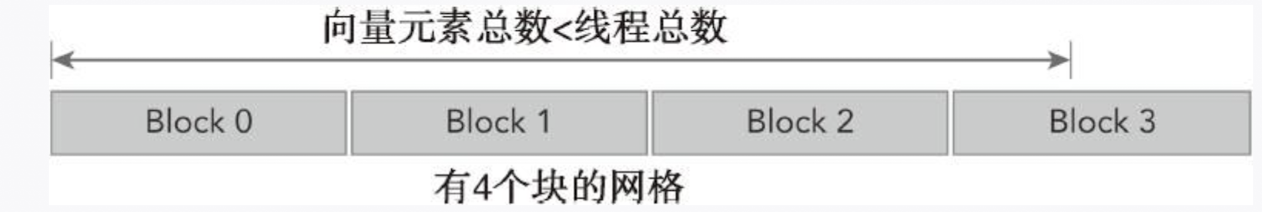

📝 2.5_sumArraysOnGPU-timer.cu

### 2.2.2 用nvprof工具计时

相比于CPU计时
- nvprof无需侵入代码
- 统计结果更加准确
- 统计数据更加直观
```bash
nvprof ./sumArraysOnGPU-timer
```
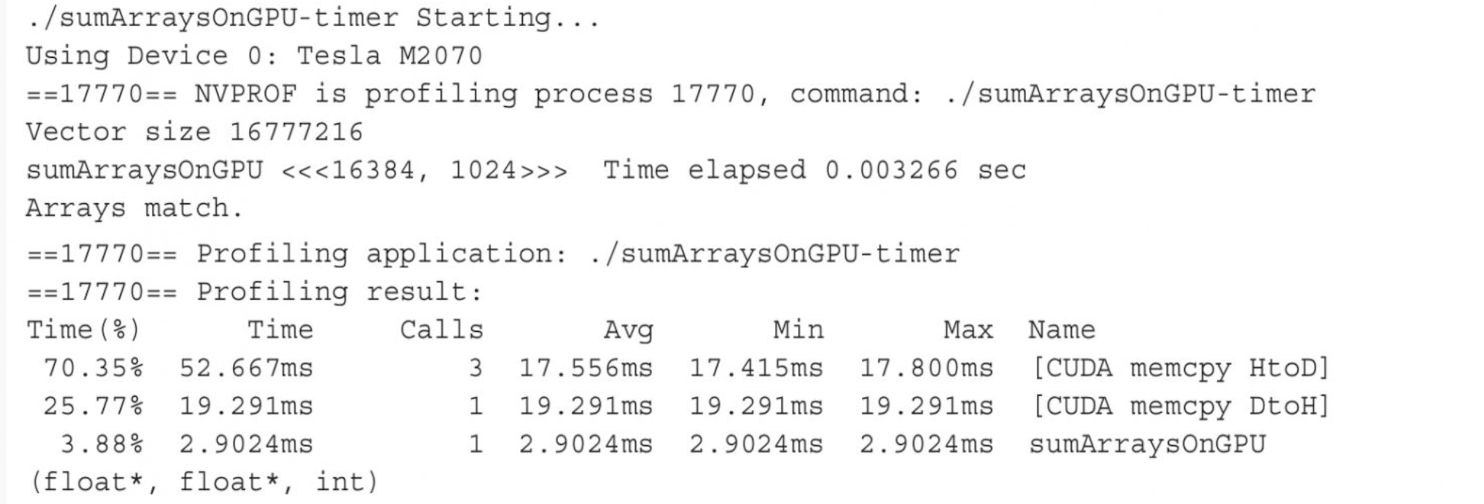

如何判断计算瓶颈还是带宽瓶颈，以Tesla K10为例
- 计算浮点计算峰值：745 MHz核心频率*2 GPU/芯片*（8个多处理器*192个浮点单元*32核心/多处理器）*2 OPS/周期＝4.58
- 计算带宽峰值：2 GPU/芯片*256位*2500 MHz内存时钟*2 DDR/8位/字节＝320 GB/s
- 计算指令比：4.58 TFLOPS/320 GB/s，也就是13.6个指令：1个字节

如果应用程序每访问一个字节产生的指令多于13.6，即每字节需要的操作多于硬件能提供的，那么应用程序出现计算瓶颈，应该优化算法

📌 类似的工具还有mcTracer、pytorch profiler

## 2.3 组织并行线程
不同场景使用不同的block大小、grid大小，对kernel性能产生很大的影响

### 2.3.1 使用块和线程建立矩阵索引
矩阵通常用行优先的方法线性存储在全局内存中
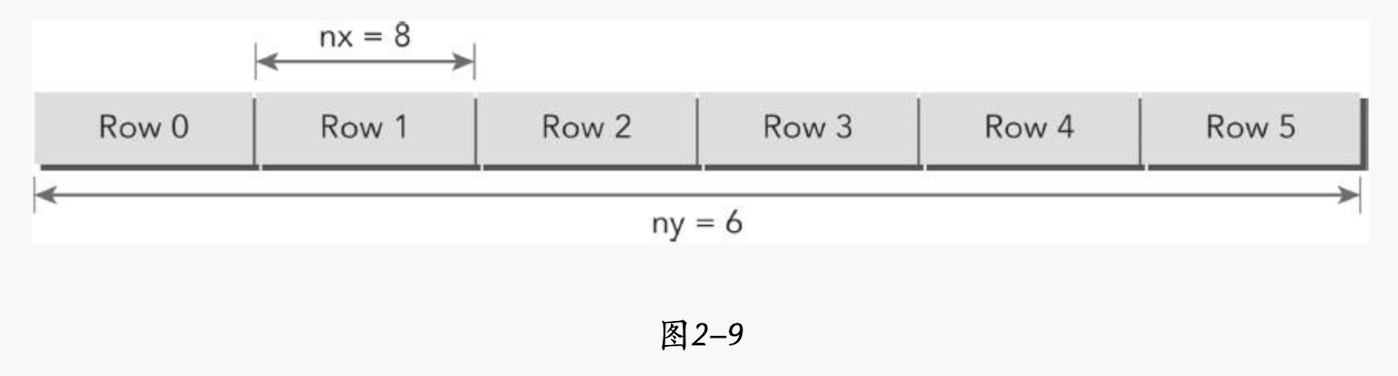

执行kernel时，一个线程通常处理一个数据元素。一个线程访问指定数据的步骤如下
- 把线程和block索引映射到矩阵坐标
```
ix = threadIdx.x + blockIdx.x * blockDim.x
iy = threadIdx.y + blockIdx.y * blockDim.y
```
- 把矩阵坐标映射到全局内存的存储单元上
```
idx = ix + nx * iy
```
📌 参考图2-9理解

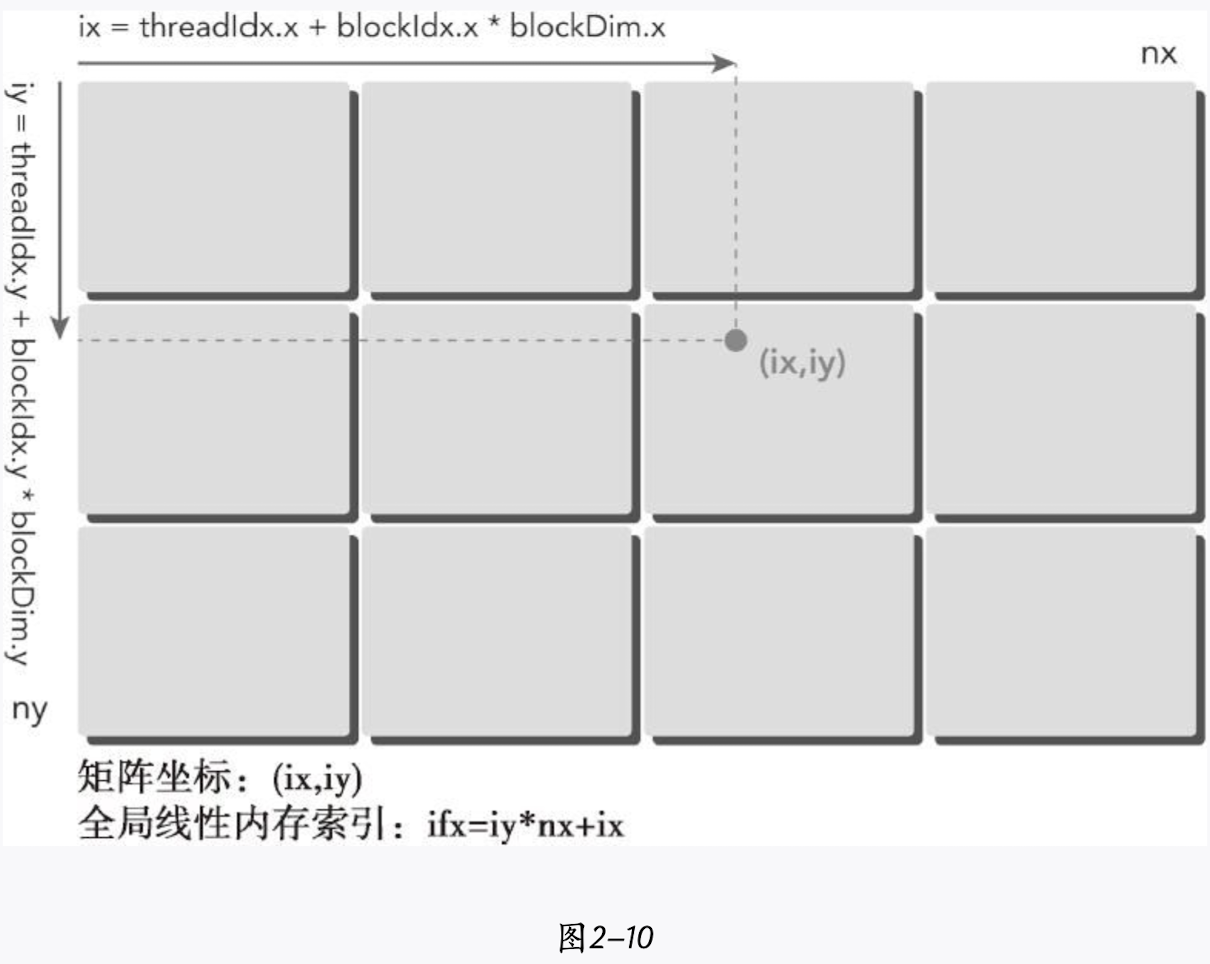
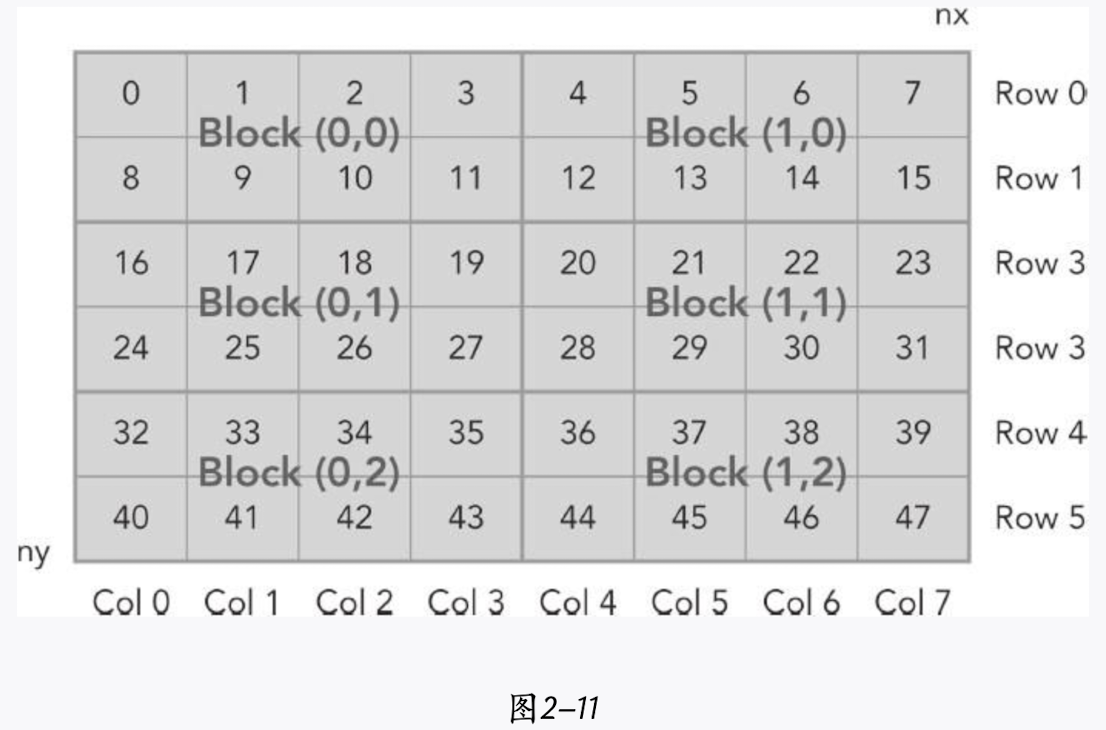

📝 2.6_checkThreadIndex.cu


### 2.3.2 使用二维网格和二维块对矩阵求和

📝 2.7_sumMatrixOnGPU-2D-grid-2D-block.cu

### 2.3.3 使用一维网格和一维块对矩阵求和
使用一维网络和一维块，ny上的线程数为1，所以每个线程需要处理ny个元素
```c
__global__ void sumMatrixOnGPU1D(float *MatA, float *MatB, float *MatC, int nx, int ny) {
    // 计算x坐标
    unsigned int ix = threadIdx.x + blockIdx.x * blockDim.x;
    if (ix < nx) {
        // 遍历x坐标下所有y坐标
        for (int iy=0; iy<ny; iy++) {
            // 将x，y坐标映射到线性数组中
            int idx = iy * nx + ix;
            MatC[idx] = MatA[idx] + Mat[idx];
        }
    }
}
```

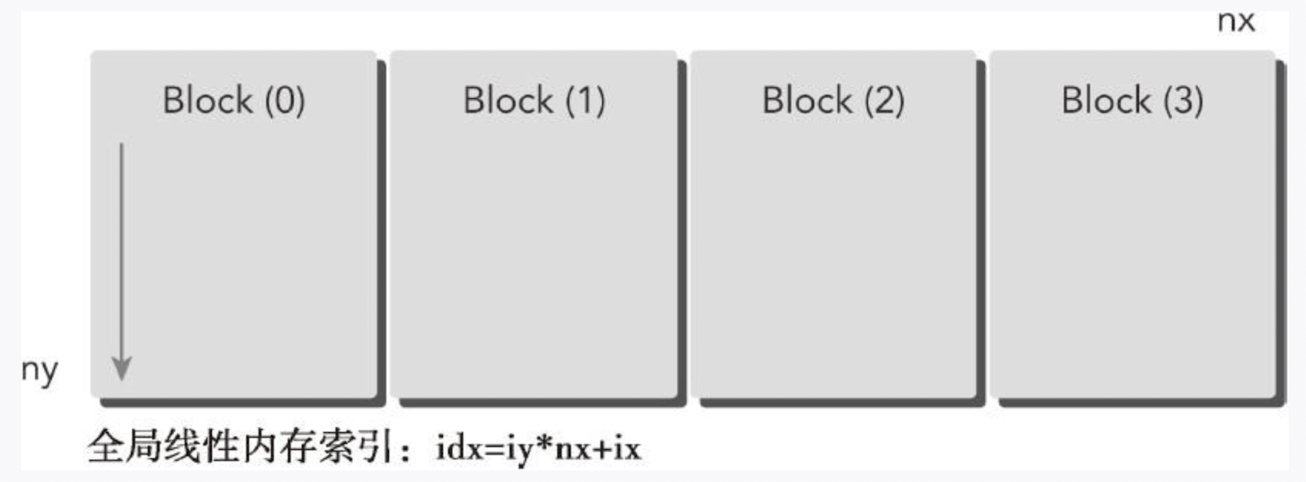

### 2.3.4 使用二维网格和一维块对矩阵求和
与二维网络和二维块类似，每个线程处理一个元素，区别在于ny计算无需考虑blockDim.y
```c
ix = threadIdx.x + blockIdx.x * blockDim.x;
iy = blockIdx.y
```
📌 这里使用二维网络和二维块的kernel，也能正常工作。新kernel唯一优点是每个线程省去了一次整数乘法和整数加法运行

## 2.4 设备管理
查询GPU设备信息由两种途径
- CUDA runtime API
- nvidia-smi命令行

### 2.4.1 使用API查询GPU信息

📝 2.8_checkDeviceInfo.cu